# Fraud Detection

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from config import db_config

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Text(0.5, 1.0, 'Distribution of Fraudulent vs Non-Fraudulent Transactions')

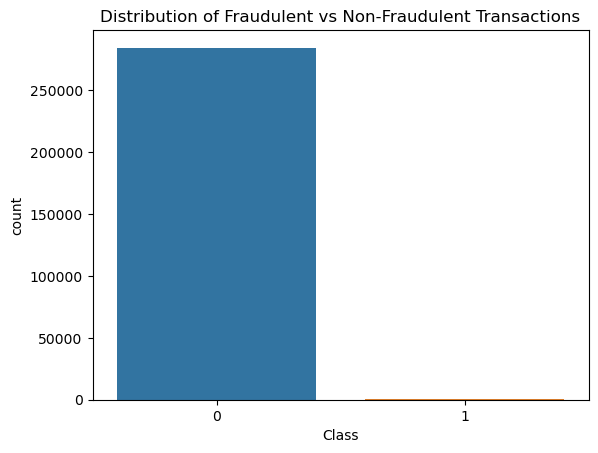

In [4]:
df = pd.read_csv('../data/creditcard.csv')

# Contoh ringkasan awal
print(df.info())
print(df.describe())

# Plot distribusi fraud vs normal
sns.countplot(data=df, x='Class')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")